In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [4]:
# Paths
RAW_PATH = Path("../data/raw/")
PROCESSED_PATH = Path("../data/processed/")
FIGURE_PATH = Path("../outputs/figures/")
MODEL_PATH = Path("../outputs/models/")

# Make sure dirs exist
PROCESSED_PATH.mkdir(parents=True, exist_ok=True)
FIGURE_PATH.mkdir(parents=True, exist_ok=True)
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Datasets
datasets = ["FD001", "FD002", "FD003", "FD004"]

# Features & labels
feature_cols = [
    "operational_setting_1", "operational_setting_2", "operational_setting_3"
] + [f"sensor_{i}" for i in range(1, 22)]
label_col = "label"  # binary (1 = near-failure, 0 = healthy)

In [6]:
def load_processed_data(dataset):
    """Load processed dataset and create binary failure label."""
    df = pd.read_csv(PROCESSED_PATH / f"train_{dataset}.csv")
    df[label_col] = (df["RUL"] <= 30).astype(int)
    return df

def split_train_val(train_df):
    """Split by engine unit to avoid leakage."""
    units = train_df["unit_number"].unique()
    train_units, val_units = train_test_split(units, test_size=0.2, random_state=42)
    
    X_train = train_df[train_df.unit_number.isin(train_units)][feature_cols]
    y_train = train_df[train_df.unit_number.isin(train_units)][label_col]
    X_val = train_df[train_df.unit_number.isin(val_units)][feature_cols]
    y_val = train_df[train_df.unit_number.isin(val_units)][label_col]
    
    return X_train, X_val, y_train, y_val

def evaluate_model(y_true, y_pred, title="Confusion Matrix"):
    """Evaluate with metrics and plot confusion matrix."""
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
    
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm).plot(cmap="Blues")
    plt.title(title)
    plt.show()
    
    return acc, prec, rec, f1

In [7]:
def train_random_forest(dataset):
    print(f"\n=== Training Random Forest on {dataset} ===")
    
    # Load data
    df = load_processed_data(dataset)
    X_train, X_val, y_train, y_val = split_train_val(df)
    
    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # Model
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
    
    rf.fit(X_train_scaled, y_train)
    y_pred = rf.predict(X_val_scaled)
    
    # Metrics
    acc, prec, rec, f1 = evaluate_model(y_val, y_pred, title=f"{dataset} Random Forest")
    
    # Save model + scaler
    joblib.dump(rf, MODEL_PATH / f"{dataset}_RandomForest.pkl")
    joblib.dump(scaler, MODEL_PATH / f"{dataset}_scaler.pkl")
    
    # Feature importance
    plt.figure(figsize=(10,6))
    importances = rf.feature_importances_
    sns.barplot(x=feature_cols, y=importances)
    plt.xticks(rotation=90)
    plt.title(f"{dataset} Random Forest Feature Importance")
    plt.tight_layout()
    plt.savefig(FIGURE_PATH / f"{dataset}_RF_feature_importance.png")
    plt.show()
    
    return {"Dataset": dataset, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1}


=== Training Random Forest on FD001 ===
Accuracy: 0.9641 | Precision: 0.8990 | Recall: 0.8613 | F1: 0.8797


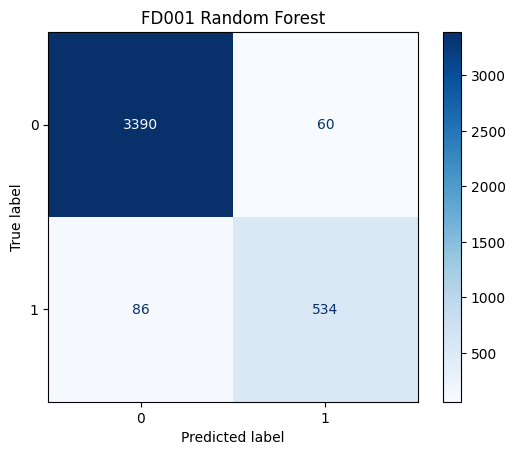

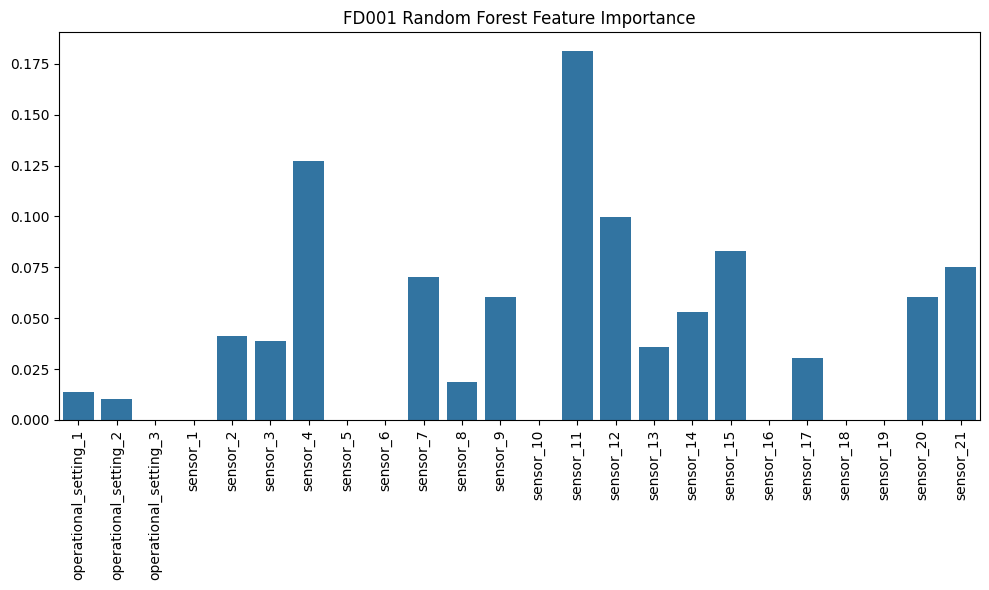


=== Training Random Forest on FD002 ===
Accuracy: 0.9558 | Precision: 0.9026 | Recall: 0.8046 | F1: 0.8508


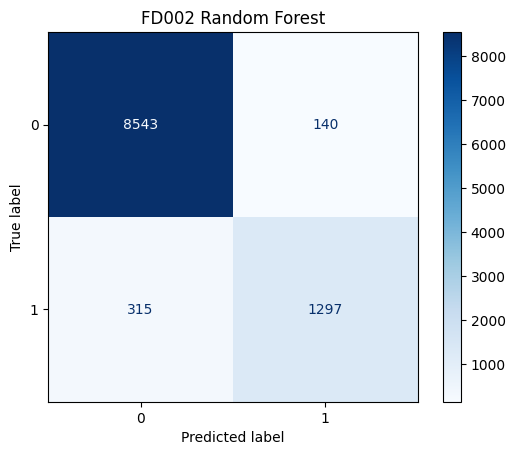

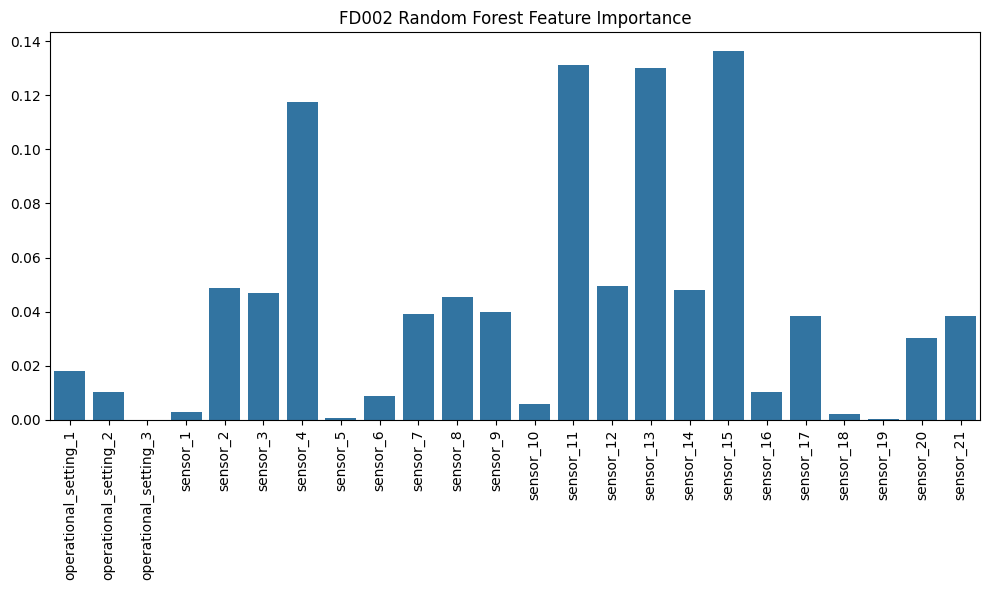


=== Training Random Forest on FD003 ===
Accuracy: 0.9684 | Precision: 0.9110 | Recall: 0.8419 | F1: 0.8751


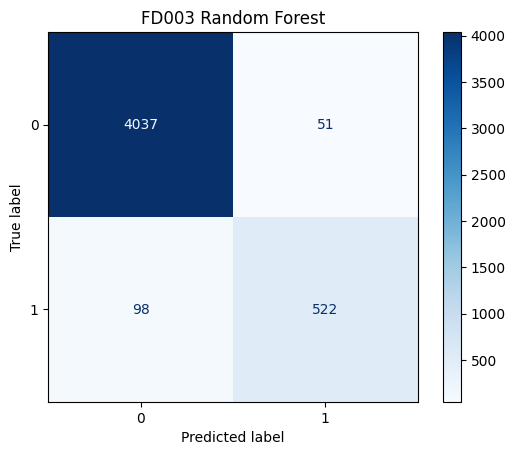

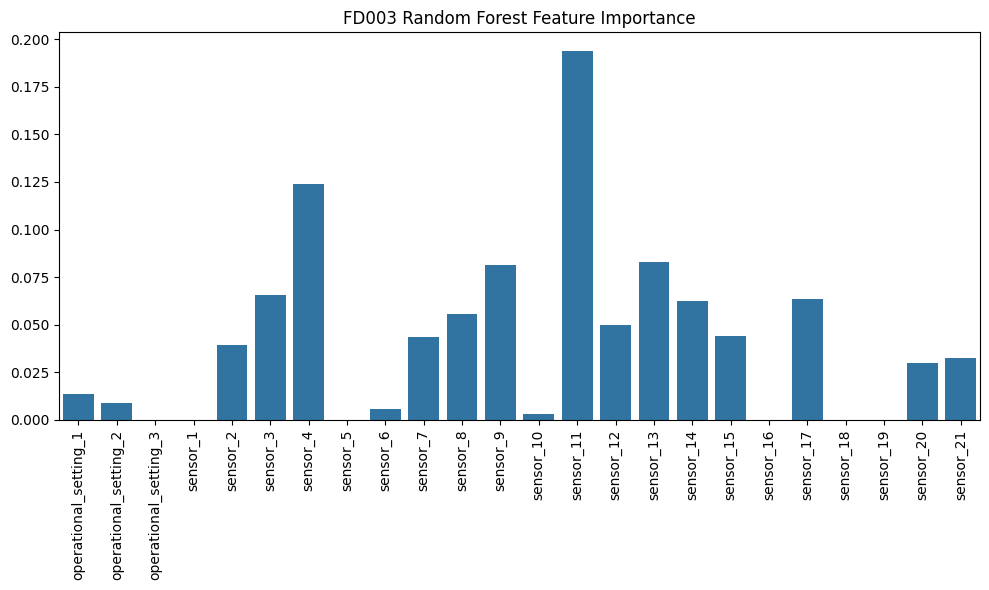


=== Training Random Forest on FD004 ===
Accuracy: 0.9537 | Precision: 0.8189 | Recall: 0.8258 | F1: 0.8224


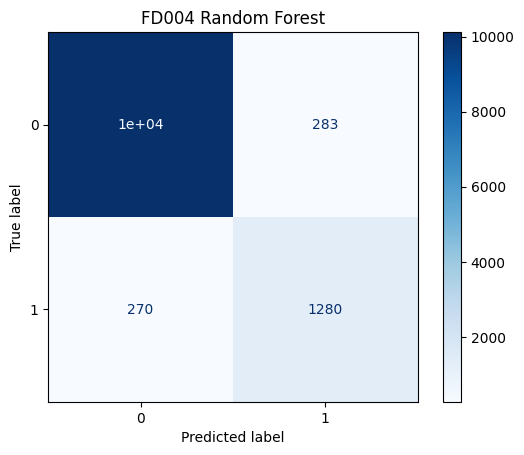

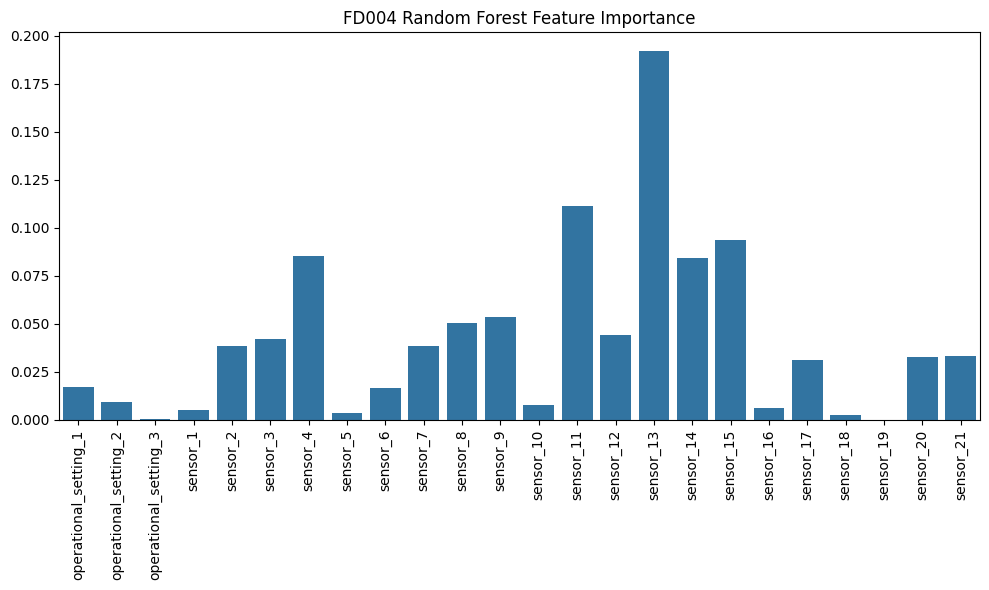

,Dataset,Accuracy,Precision,Recall,F1
0,FD001,0.964128,0.898990,0.861290,0.879736
1,FD002,0.955804,0.902575,0.804591,0.850771
2,FD003,0.968352,0.910995,0.841935,0.875105
3,FD004,0.953743,0.818938,0.825806,0.822358


In [8]:
all_results = []

for ds in datasets:
    result = train_random_forest(ds)
    all_results.append(result)

results_df = pd.DataFrame(all_results)
results_df

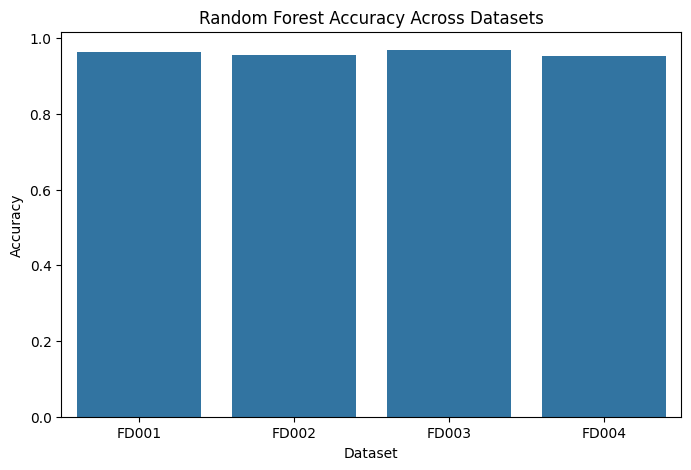

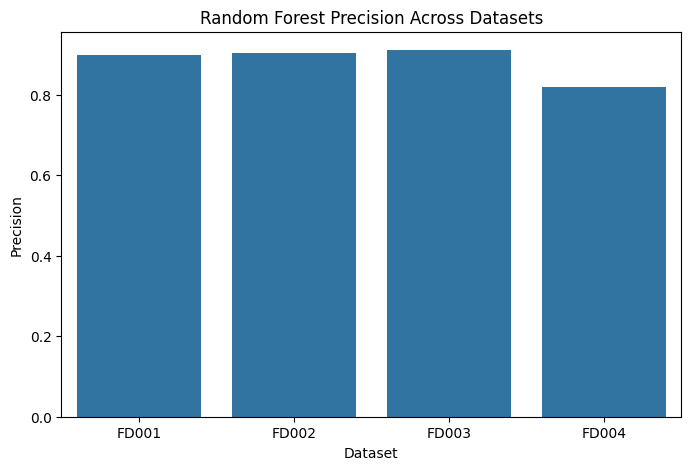

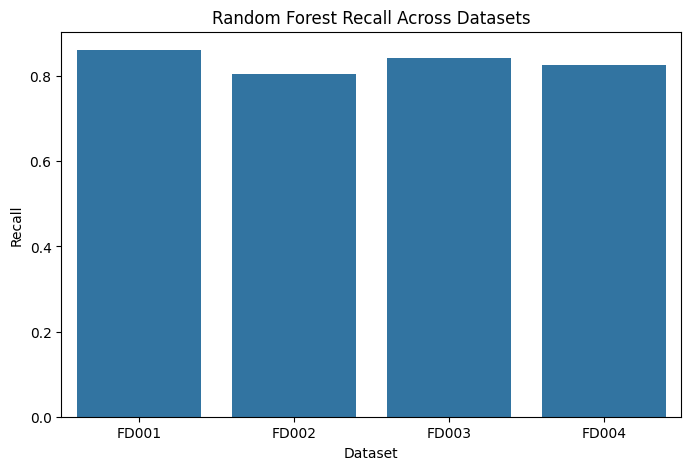

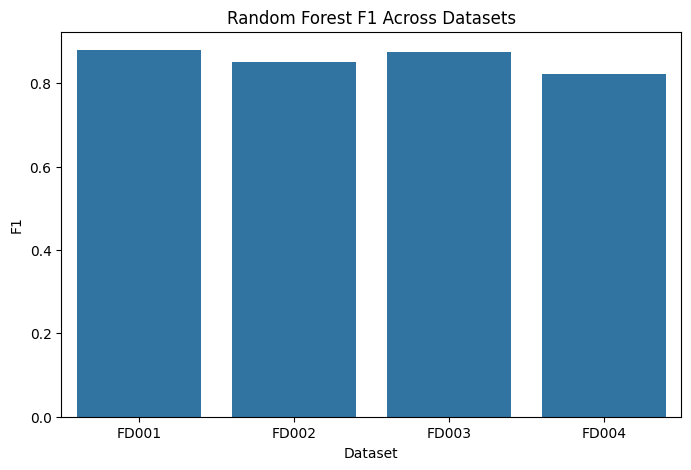

In [9]:
metrics = ["Accuracy", "Precision", "Recall", "F1"]

for metric in metrics:
    plt.figure(figsize=(8,5))
    sns.barplot(x="Dataset", y=metric, data=results_df)
    plt.title(f"Random Forest {metric} Across Datasets")
    plt.savefig(FIGURE_PATH / f"RF_{metric}_comparison.png")
    plt.show()